In [1]:
import os
import math
import random
import shutil
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import keras
import seaborn as sns

In [17]:
def get_image_sizes(directory):
    image_widths = []
    image_heights = []

    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more extensions if needed
            file_path = os.path.join(directory, filename)
            with Image.open(file_path) as img:
                width, height = img.size
                image_widths.append(width)
                image_heights.append(height)

    return image_widths, image_heights

directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train'
image_widths, image_heights = get_image_sizes(directory_path)


(200.0, 800.0)

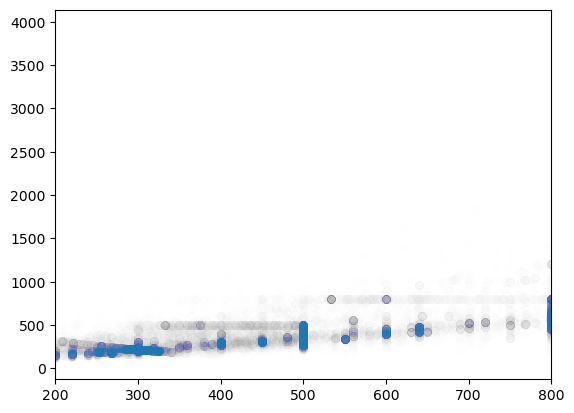

In [36]:
plt.scatter(image_widths, image_heights, alpha=0.002)
plt.xlim(200, 800)

In [49]:
# Testing out for the relative sizes of the bounding boxes

from PIL import Image, ImageDraw

image = Image.open('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP000000002.jpg')
image = image.resize((300, 300))
img_draw = ImageDraw.Draw(image)

target_size = image.size
x_center, y_center, width, height = 0.31, 0.43833333333333335, 0.355, 0.4766666666666667
x_min = (x_center - width / 2) * target_size[0]
y_min = (y_center - height / 2) * target_size[1]
x_max = (x_center + width / 2) * target_size[0]
y_max = (y_center + height / 2) * target_size[1]

img_draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=2)
        
image.show()

In [344]:
# Autoencoder Architecture

# Input layer
input_shape = (304, 304, 3)  # Assuming RGB images
input_img = Input(shape=input_shape)

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer with 3 channels for RGB

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 conv2d_111 (Conv2D)         (None, 304, 304, 64)      1792      
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 152, 152, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 152, 152, 128)     73856     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 76, 76, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 76, 76, 256)       295

In [3]:
image = tf.io.read_file('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP000000000.jpg')
image = tf.image.decode_jpeg(image, channels=3)

In [4]:
noise_img = tf.image.resize(image, [304, 304]).numpy()/255 + np.random.normal(scale=0.1, size=(304, 304, 3))

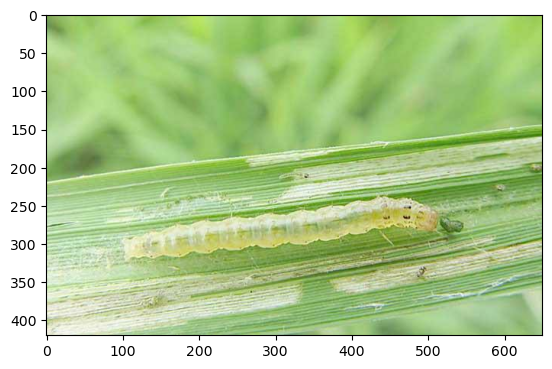

In [18]:
plt.imshow(image)
plt.show()

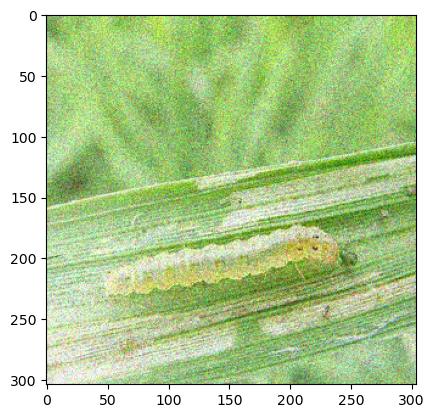

In [19]:
plt.imshow(np.clip(noise_img, 0., 1.))

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x_arr, batch_size=32, shuffle=True):
        # x_arr: Image file paths
        
        self.x_arr = x_arr
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.x_arr))
        np.random.shuffle(self.indexes)
        
    def preprocess_images(self, x_arr, noise):
        images = []
        max_shape = [1, 1]
        for image in x_arr:
            image = tf.io.read_file(image)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, [304, 304]).numpy()/255
            if noise:
                image += np.random.normal(scale=0.1, size=(304, 304, 3))
                image = np.clip(image, 0., 1.)
            images.append(image)
        
        X = np.array(images)
        return X
            
        
    def __getitem__(self, index):
        index = int(index)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.preprocess_images(self.x_arr[indexes], True)
        y = self.preprocess_images(self.x_arr[indexes], False)
        
        return X, y
    
    def __len__(self):
        return math.floor(len(self.x_arr) / self.batch_size)
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [24]:
directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/val'

# Get the list of files in the directory
file_list = os.listdir(directory_path)
file_list = list(map(lambda x: '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/val/' + x, file_list))

In [25]:
dg = DataGenerator(np.array(file_list))

In [26]:
steps_per_epoch = len(dg)

In [27]:
steps_per_epoch

41

In [233]:
predict_img = autoencoder.predict(np.array([noise_img]))

1/1 [==============================] - 0s 69ms/step


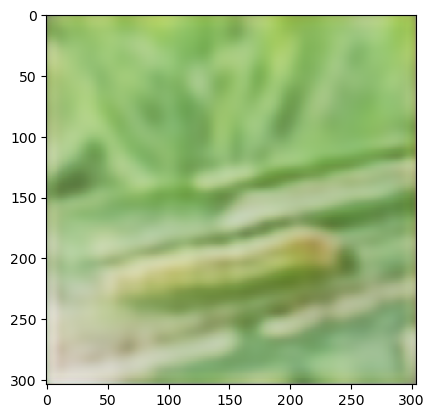

In [235]:
plt.imshow(predict_img[0])

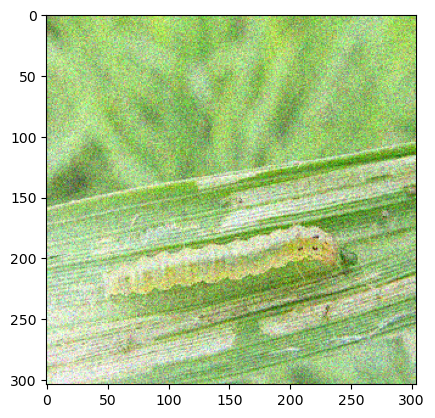

In [236]:
plt.imshow(noise_img)

### Dataset Preparation -- Start

In [2]:
# Class: List of filenames

train_class_d = {k:[] for k in range(102)}

train_directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/labels/train'

train_files_list = os.listdir(train_directory_path)

for file in train_files_list:
    with open(train_directory_path + '/' + file, 'r') as cur_file:
        lines = cur_file.readlines()
        if len(lines) >= 2:
            continue
        cls = lines[0].split()[0]
        train_class_d[int(cls)].append(train_directory_path + '/' + file)

In [3]:
# Class: List of filenames

val_class_d = {k:[] for k in range(102)}

val_directory_path = '/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/labels/val'

val_files_list = os.listdir(val_directory_path)

for file in val_files_list:
    with open(val_directory_path + '/' + file, 'r') as cur_file:
        lines = cur_file.readlines()
        if len(lines) >= 2:
            continue
        cls = lines[0].split()[0]
        val_class_d[int(cls)].append(val_directory_path + '/' + file)

In [4]:
complete_class_d = {}

for i in range(102):
    complete_class_d[i] = train_class_d[i] + val_class_d[i]

In [5]:
classes_map = {3: 0, 15: 1, 24: 2, 39: 3, 45: 4, 51: 5, 67: 6, 70: 7, 86: 8, 101: 9}

classes = {
    3: 'asiatic rice borer', 
    15: 'mole cricket', 
    24: 'aphids', 
    39: 'beet army worm', 
    45: 'flax budworm', 
    51: 'blister beetle', 
    67: 'Lycorma delicatula', 
    70: 'Miridae', 
    86: 'Prodenia litura', 
    101: 'Cicadellidae'
}

seed_value = 42
random.seed(seed_value)

subset_classes_files = {}
for i in classes:
    subset_classes_files[classes_map[i]] = random.sample(complete_class_d[i], 80)

In [6]:
classes.values()

dict_values(['asiatic rice borer', 'mole cricket', 'aphids', 'beet army worm', 'flax budworm', 'blister beetle', 'Lycorma delicatula', 'Miridae', 'Prodenia litura', 'Cicadellidae'])

In [7]:
subset_classes_label_files = subset_classes_files.copy()
subset_classes_image_files = subset_classes_files.copy()

for i in subset_classes_image_files:
    subset_classes_image_files[i] = list(map(lambda x: x.replace('labels', 'images').replace('.txt', '.jpg'), subset_classes_image_files[i]))

In [8]:
for i in subset_classes_label_files:
    for file in subset_classes_label_files[i]:
        with open(file, 'r+') as f:
            content = f.readline().split()
            content[0] = str(classes_map[int(content[0])])
            f.seek(0)
            f.write(' '.join(content))

In [9]:
train_image_files = []
val_image_files = []
test_image_files = []

train_label_files = []
val_label_files = []
test_label_files = []


for i in subset_classes_image_files:
    train_image_files.extend(subset_classes_image_files[i][:64])
    val_image_files.extend(subset_classes_image_files[i][64:72])
    test_image_files.extend(subset_classes_image_files[i][72:])

for i in subset_classes_label_files:
    train_label_files.extend(subset_classes_label_files[i][:64])
    val_label_files.extend(subset_classes_label_files[i][64:72])
    test_label_files.extend(subset_classes_label_files[i][72:])

### Dataset Preparation -- End

### Autoencoder Training

In [12]:
train_gen = DataGenerator(np.array(train_image_files))
val_gen = DataGenerator(np.array(val_image_files))
test_gen = DataGenerator(np.array(test_image_files))

In [13]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

In [365]:
history = autoencoder.fit(train_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 149s 7s/step - loss: 0.0524 - val_loss: 0.0255
Epoch 2/10
20/20 [==============================] - 152s 8s/step - loss: 0.0212 - val_loss: 0.0175
Epoch 3/10
20/20 [==============================] - 152s 8s/step - loss: 0.0149 - val_loss: 0.0109
Epoch 4/10
20/20 [==============================] - 170s 8s/step - loss: 0.0101 - val_loss: 0.0098
Epoch 5/10
20/20 [==============================] - 174s 9s/step - loss: 0.0081 - val_loss: 0.0071
Epoch 6/10
20/20 [==============================] - 174s 9s/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/10
20/20 [==============================] - 174s 9s/step - loss: 0.0061 - val_loss: 0.0051
Epoch 8/10
20/20 [==============================] - 183s 9s/step - loss: 0.0057 - val_loss: 0.0057
Epoch 9/10
20/20 [==============================] - 183s 9s/step - loss: 0.0053 - val_loss: 0.0046
Epoch 10/10
20/20 [==============================] - 182s 9s/step - loss: 0.0049 - val_loss: 0.0048


In [395]:
history2 = autoencoder.fit(train_gen, epochs=10, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps)

Epoch 1/10
20/20 [==============================] - 152s 8s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 2/10
20/20 [==============================] - 153s 8s/step - loss: 0.0044 - val_loss: 0.0039
Epoch 3/10
20/20 [==============================] - 154s 8s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 4/10
20/20 [==============================] - 175s 9s/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
20/20 [==============================] - 181s 9s/step - loss: 0.0043 - val_loss: 0.0041
Epoch 6/10
20/20 [==============================] - 185s 9s/step - loss: 0.0041 - val_loss: 0.0037
Epoch 7/10
20/20 [==============================] - 174s 9s/step - loss: 0.0039 - val_loss: 0.0033
Epoch 8/10
20/20 [==============================] - 167s 8s/step - loss: 0.0039 - val_loss: 0.0034
Epoch 9/10
20/20 [==============================] - 178s 9s/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/10
20/20 [==============================] - 176s 9s/step - loss: 0.0037 - val_loss: 0.0038


In [420]:
save_best_cb = keras.callbacks.ModelCheckpoint('./autoencoder/checkpoint', save_best_only=True) # Saves the best model so far
stop_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [421]:
history3 = autoencoder.fit(train_gen, epochs=30, steps_per_epoch=steps_per_epoch, validation_data=val_gen, validation_steps=validation_steps, callbacks=[save_best_cb, stop_cb])

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 151s 8s/step - loss: 0.0036 - val_loss: 0.0035
Epoch 2/30
20/20 [==============================] - 162s 8s/step - loss: 0.0035 - val_loss: 0.0041
Epoch 3/30
20/20 [==============================] - 180s 9s/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 181s 9s/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/30
20/20 [==============================] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 193s 10s/step - loss: 0.0035 - val_loss: 0.0033
Epoch 6/30
20/20 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


INFO:tensorflow:Assets written to: ./autoencoder/checkpoint/assets


20/20 [==============================] - 183s 9s/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/30
20/20 [==============================] - 178s 9s/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/30
20/20 [==============================] - 177s 9s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/30
20/20 [==============================] - 176s 9s/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/30
20/20 [==============================] - 178s 9s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/30
20/20 [==============================] - 179s 9s/step - loss: 0.0033 - val_loss: 0.0031


### AE Predictions

In [101]:
best_model = keras.models.load_model('./autoencoder/checkpoint/')

In [46]:
image = tf.io.read_file('/Users/sathwick/SDrive/work/pest-detection/data/IP102_YOLOv5/images/train/IP003000866.jpg')
image = tf.image.decode_jpeg(image, channels=3)

noise_img = tf.image.resize(image, [304, 304]).numpy()/255 + np.random.normal(scale=0.1, size=(304, 304, 3))

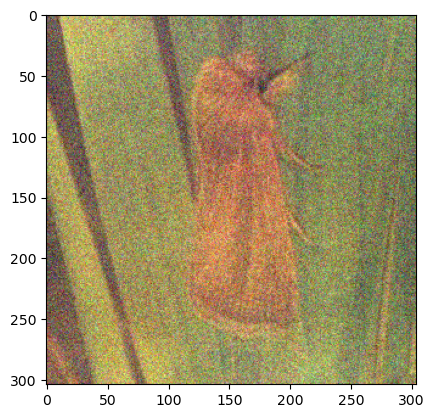

In [399]:
plt.imshow(noise_img)

In [424]:
predict_img = best_model.predict(np.array([noise_img]))

1/1 [==============================] - 0s 112ms/step


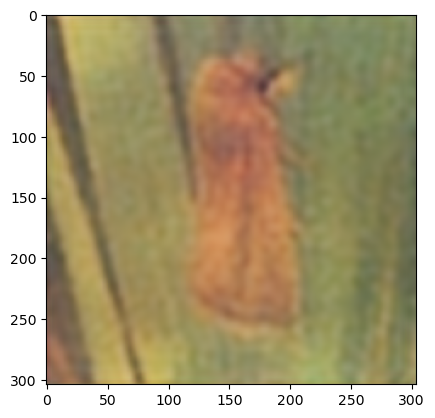

In [425]:
plt.imshow(predict_img[0])

In [21]:
steps = len(test_gen)

In [23]:
best_model.evaluate(test_gen, steps=steps)

2/2 [==============================] - 4s 2s/step - loss: 0.0037


0.003725675866007805

### Saving the Model

In [417]:
# with open('./autoencoder/history1', 'wb') as history_file:
#     pickle.dump(history.history, history_file)

In [418]:
# with open('./autoencoder/history2', 'wb') as history_file:
#     pickle.dump(history2.history, history_file)

In [422]:
# with open('./autoencoder/history3', 'wb') as history_file:
#     pickle.dump(history3.history, history_file)

In [419]:
# autoencoder.save('./autoencoder/best_model.keras')

In [81]:
def get_train_val_plots(h, yticks=None, figsize=(10, 5)):
    # h: Any dictionary like the history.history
    
    fig, ax = plt.subplots(figsize=figsize)
    n_epochs = len(h['loss'])
    x_loss = np.arange(n_epochs+1)-0.5
    
    ax.plot(x_loss[x_loss >= 0], h['loss'], color='b', label='train_loss')
    ax.plot(range(1, n_epochs+1), h['val_loss'], color='r', label='val_loss')
    # ax.set_xlim(0, n_epochs)
    # ax.set_xticks(range(1, n_epochs+1))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    if yticks is not None:
        ax.set_yticks(yticks)
    ax.legend()

In [82]:
h1 = np.load('./autoencoder/history1', allow_pickle=True)
h2 = np.load('./autoencoder/history2', allow_pickle=True)
h3 = np.load('./autoencoder/history3', allow_pickle=True)

In [83]:
h = {'loss': [], 'val_loss': []}

for history in [h1, h2, h3]:
    for loss in history:
        h[loss].extend(history[loss])

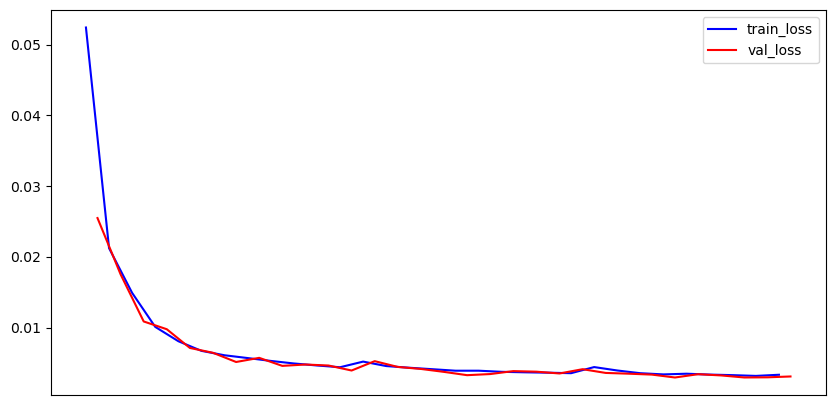

In [84]:
get_train_val_plots(h)

## Creating the Test Directories

In [95]:
left_out = {k: [] for k in range(10)}

for i in range(10):
    for x in subset_classes_image_files[i]:
        if x in [*train_image_files[i], val_image_files[i], test_image_files[i]]:
            continue
        left_out[i].append(x)

In [96]:
left_out_list = []

for i in left_out:
    left_out_list.extend(left_out[i])

for i in left_out_list:
    shutil.copy(i, '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/')

In [97]:
left_out = {k: [] for k in range(10)}

for i in range(10):
    for x in subset_classes_label_files[i]:
        if x in [*train_label_files[i], val_label_files[i], test_label_files[i]]:
            continue
        left_out[i].append(x)

In [98]:
import shutil

left_out_list = []

for i in left_out:
    left_out_list.extend(left_out[i])

for i in left_out_list:
    shutil.copy(i, '/Users/sathwick/SDrive/work/pest-detection/data/test copy/labels/')

## YOLO

In [39]:
from ultralytics import YOLO

In [30]:
y_model = YOLO('./data/best.pt')

im = Image.open('./IP003000504.jpg')
results = y_model.predict(source=im, conf=0.5)


0: 256x320 1 asiatic rice borer, 45.1ms
Speed: 3.5ms preprocess, 45.1ms inference, 7.2ms postprocess per image at shape (1, 3, 256, 320)


In [31]:
im_bgr = results[0].plot(conf=False)
im_rgb = Image.fromarray(im_bgr[..., ::-1])

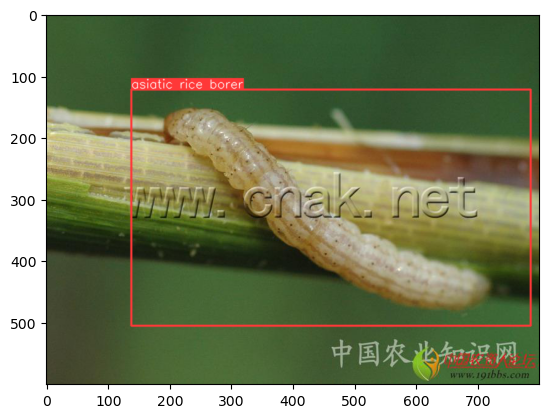

In [32]:
plt.imshow(im_rgb)

In [103]:
results_all = y_model.predict(source='/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/', conf=0.5)


image 1/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000008.jpg: 192x320 1 asiatic rice borer, 43.4ms
image 2/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000022.jpg: 256x320 1 asiatic rice borer, 24.1ms
image 3/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000059.jpg: 192x320 1 asiatic rice borer, 15.0ms
image 4/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000064.jpg: 224x320 1 asiatic rice borer, 17.5ms
image 5/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000074.jpg: 224x320 1 asiatic rice borer, 15.1ms
image 6/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000085.jpg: 256x320 1 asiatic rice borer, 18.5ms
image 7/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000102.jpg: 256x320 1 Prodenia litura, 16.4ms
image 8/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000

image 64/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000855.jpg: 256x320 1 asiatic rice borer, 23.3ms
image 65/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000857.jpg: 256x320 1 asiatic rice borer, 17.8ms
image 66/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000866.jpg: 256x320 1 asiatic rice borer, 15.9ms
image 67/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000876.jpg: 256x320 1 asiatic rice borer, 17.7ms
image 68/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000890.jpg: 256x320 1 asiatic rice borer, 15.8ms
image 69/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000909.jpg: 320x320 1 asiatic rice borer, 24.2ms
image 70/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000979.jpg: 288x320 1 asiatic rice borer, 19.4ms
image 71/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/image

image 129/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001101.jpg: 224x320 1 mole cricket, 21.9ms
image 130/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001158.jpg: 224x320 1 mole cricket, 19.4ms
image 131/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001213.jpg: 160x320 1 mole cricket, 13.9ms
image 132/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001216.jpg: 224x320 1 mole cricket, 21.7ms
image 133/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001235.jpg: 224x320 1 mole cricket, 19.6ms
image 134/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001243.jpg: 256x320 1 mole cricket, 23.0ms
image 135/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001287.jpg: 224x320 1 mole cricket, 17.3ms
image 136/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001297.jpg: 256x320 1 mole 

image 196/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001520.jpg: 288x320 1 aphids, 24.1ms
image 197/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001525.jpg: 224x320 1 aphids, 20.2ms
image 198/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001526.jpg: 192x320 1 aphids, 18.5ms
image 199/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001535.jpg: 288x320 1 aphids, 24.3ms
image 200/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001582.jpg: 288x320 1 aphids, 26.6ms
image 201/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001668.jpg: 288x320 1 aphids, 23.1ms
image 202/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001695.jpg: 320x320 1 aphids, 21.1ms
image 203/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001697.jpg: 224x320 1 aphids, 19.0ms
image 204/799 /Users/sathwick/SD

image 263/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000317.jpg: 192x320 1 beet army worm, 20.9ms
image 264/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000334.jpg: 224x320 1 beet army worm, 17.9ms
image 265/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000348.jpg: 256x320 1 beet army worm, 20.1ms
image 266/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000349.jpg: 288x320 1 beet army worm, 22.4ms
image 267/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000361.jpg: 192x320 1 beet army worm, 13.7ms
image 268/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000376.jpg: 224x320 1 beet army worm, 16.9ms
image 269/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000382.jpg: 256x320 1 beet army worm, 19.9ms
image 270/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000394.jpg: 2

image 327/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000090.jpg: 256x320 1 flax budworm, 20.0ms
image 328/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000096.jpg: 288x320 1 flax budworm, 19.3ms
image 329/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000127.jpg: 256x320 1 flax budworm, 18.1ms
image 330/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000133.jpg: 224x320 1 flax budworm, 19.5ms
image 331/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000160.jpg: 224x320 1 flax budworm, 20.1ms
image 332/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000162.jpg: 224x320 1 flax budworm, 16.3ms
image 333/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000163.jpg: 320x320 1 flax budworm, 23.2ms
image 334/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000167.jpg: 256x320 1 flax 

image 392/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001022.jpg: 224x320 1 flax budworm, 19.5ms
image 393/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001027.jpg: 224x320 1 flax budworm, 17.1ms
image 394/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001029.jpg: 320x288 1 flax budworm, 24.5ms
image 395/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001032.jpg: 320x320 1 flax budworm, 21.1ms
image 396/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001036.jpg: 256x320 1 flax budworm, 20.2ms
image 397/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001046.jpg: 256x320 1 flax budworm, 15.1ms
image 398/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001060.jpg: 224x320 1 flax budworm, 18.0ms
image 399/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001063.jpg: 256x320 1 flax 

image 456/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001420.jpg: 256x320 1 blister beetle, 20.8ms
image 457/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001421.jpg: 224x320 1 blister beetle, 16.9ms
image 458/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001486.jpg: 320x224 1 blister beetle, 20.9ms
image 459/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001524.jpg: 288x320 1 blister beetle, 18.8ms
image 460/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001530.jpg: 256x320 1 blister beetle, 19.8ms
image 461/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001541.jpg: 320x192 1 blister beetle, 15.5ms
image 462/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001558.jpg: 224x320 1 blister beetle, 17.0ms
image 463/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001563.jpg: 3

image 519/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003289.jpg: 256x320 1 Lycorma delicatula, 23.2ms
image 520/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003363.jpg: 256x320 1 Lycorma delicatula, 20.0ms
image 521/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003415.jpg: 320x256 1 Lycorma delicatula, 19.8ms
image 522/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003424.jpg: 320x256 1 Lycorma delicatula, 19.5ms
image 523/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003597.jpg: 288x320 1 Lycorma delicatula, 21.9ms
image 524/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003601.jpg: 224x320 1 Cicadellidae, 19.2ms
image 525/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003602.jpg: 224x320 1 Lycorma delicatula, 16.4ms
image 526/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/ima

image 583/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001747.jpg: 192x320 1 Miridae, 17.1ms
image 584/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001778.jpg: 320x320 1 Miridae, 20.6ms
image 585/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001864.jpg: 256x320 1 Miridae, 15.9ms
image 586/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001988.jpg: 288x320 1 Miridae, 27.3ms
image 587/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002056.jpg: 192x320 1 Miridae, 14.5ms
image 588/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002128.jpg: 224x320 1 Miridae, 17.9ms
image 589/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002192.jpg: 320x320 1 Miridae, 21.0ms
image 590/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002239.jpg: 320x256 1 Miridae, 21.8ms
image 591/799 /Users/sat

image 650/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000241.jpg: 224x320 1 Prodenia litura, 27.9ms
image 651/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000258.jpg: 256x320 1 Prodenia litura, 20.9ms
image 652/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000284.jpg: 256x320 1 Prodenia litura, 21.0ms
image 653/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000288.jpg: 224x320 1 Prodenia litura, 16.2ms
image 654/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000310.jpg: 320x320 1 Prodenia litura, 20.3ms
image 655/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000350.jpg: 224x320 1 Prodenia litura, 16.9ms
image 656/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000356.jpg: 192x320 1 Prodenia litura, 15.4ms
image 657/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000392

image 714/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001178.jpg: 224x320 1 Prodenia litura, 23.7ms
image 715/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001218.jpg: 224x320 1 Prodenia litura, 20.2ms
image 716/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001227.jpg: 224x320 1 Prodenia litura, 15.2ms
image 717/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001245.jpg: 256x320 1 Prodenia litura, 23.7ms
image 718/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001254.jpg: 256x320 1 Prodenia litura, 19.6ms
image 719/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001257.jpg: 256x320 1 beet army worm, 15.1ms
image 720/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000125.jpg: 224x320 1 Cicadellidae, 15.0ms
image 721/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000263.jpg

image 779/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102003896.jpg: 224x320 1 Cicadellidae, 15.2ms
image 780/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004043.jpg: 256x320 1 Cicadellidae, 21.1ms
image 781/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004078.jpg: 256x320 1 Cicadellidae, 21.7ms
image 782/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004117.jpg: 256x320 1 Cicadellidae, 18.8ms
image 783/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004225.jpg: 320x256 1 Cicadellidae, 20.3ms
image 784/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004249.jpg: 320x224 1 Cicadellidae, 16.5ms
image 785/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004292.jpg: 224x320 1 Cicadellidae, 15.7ms
image 786/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004325.jpg: 320x320 1 Cicad

In [111]:
def get_accuracy(results):
    ctr = 0

    for result in results:
        with open(result.path.replace('images', 'labels').replace('jpg', 'txt'), 'r') as f:
            result_cls = result.boxes.cls
            cur_cls = int(f.readline().split()[0])
            if cur_cls in result_cls:
                ctr += 1
    return ctr/len(results) * 100

In [112]:
get_accuracy(results_all)

93.86733416770964

In [128]:
def get_conf_mat(results):
    ctr = 0
    matrix = [[0 for i in range(10)] for i in range(10)]
    
    for result in results:
        with open(result.path.replace('images', 'labels').replace('jpg', 'txt'), 'r') as f:
            result_cls = result.boxes.cls
            cur_cls = int(f.readline().split()[0])
            for i in result_cls.tolist():
                matrix[int(i)][cur_cls] += 1
    return matrix

In [130]:
len(results_all)

799

In [131]:
conf_mat = get_conf_mat(results_all)

In [132]:
conf_mat_arr = np.array(conf_mat)

In [141]:
conf_mat

[[77, 0, 1, 0, 3, 2, 0, 0, 3, 2],
 [0, 80, 0, 2, 7, 1, 0, 0, 1, 1],
 [0, 0, 74, 1, 0, 0, 0, 2, 0, 0],
 [0, 0, 0, 76, 3, 1, 0, 1, 6, 0],
 [0, 0, 0, 1, 68, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 76, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 79, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 75, 1, 1],
 [1, 0, 1, 0, 0, 0, 0, 2, 69, 0],
 [1, 0, 1, 0, 0, 1, 1, 0, 0, 76]]

In [158]:
np.sum(conf_mat_arr, axis=0)

array([79, 80, 78, 81, 81, 81, 80, 80, 81, 81])

In [159]:
conf_matrix_percent = conf_mat_arr / np.sum(conf_mat_arr, axis=0)

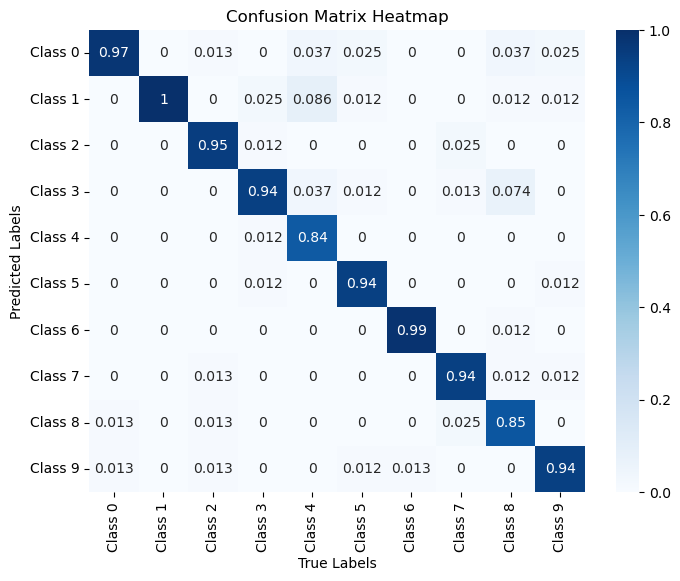

In [160]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap="Blues",
            xticklabels=[f'Class {i}' for i in range(10)],
            yticklabels=[f'Class {i}' for i in range(10)])


plt.title('Confusion Matrix Heatmap')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [164]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [168]:
77/(79), 77/(88)

(0.9746835443037974, 0.875)

In [166]:
conf_mat

[[77, 0, 1, 0, 3, 2, 0, 0, 3, 2],
 [0, 80, 0, 2, 7, 1, 0, 0, 1, 1],
 [0, 0, 74, 1, 0, 0, 0, 2, 0, 0],
 [0, 0, 0, 76, 3, 1, 0, 1, 6, 0],
 [0, 0, 0, 1, 68, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 76, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 79, 0, 1, 0],
 [0, 0, 1, 0, 0, 0, 0, 75, 1, 1],
 [1, 0, 1, 0, 0, 0, 0, 2, 69, 0],
 [1, 0, 1, 0, 0, 1, 1, 0, 0, 76]]

In [169]:
np.sum(conf_mat, axis=1)

array([88, 92, 77, 87, 69, 78, 80, 78, 73, 80])

In [170]:
np.sum(conf_mat, axis=0)

array([79, 80, 78, 81, 81, 81, 80, 80, 81, 81])

In [173]:
pre = {}
recall = {}
s_0 = np.sum(conf_mat, axis=0)
s_1 = np.sum(conf_mat, axis=1)

for i in range(10):
    pre[i] = conf_mat[i][i]/s_1[i]
    recall[i] = conf_mat[i][i]/s_0[i]

In [174]:
pre

{0: 0.875,
 1: 0.8695652173913043,
 2: 0.961038961038961,
 3: 0.8735632183908046,
 4: 0.9855072463768116,
 5: 0.9743589743589743,
 6: 0.9875,
 7: 0.9615384615384616,
 8: 0.9452054794520548,
 9: 0.95}

In [175]:
recall

{0: 0.9746835443037974,
 1: 1.0,
 2: 0.9487179487179487,
 3: 0.9382716049382716,
 4: 0.8395061728395061,
 5: 0.9382716049382716,
 6: 0.9875,
 7: 0.9375,
 8: 0.8518518518518519,
 9: 0.9382716049382716}

In [29]:
# Autoencoder Architecture

# Input layer
input_shape = (304, 304, 3)  # Assuming RGB images
input_img = Input(shape=input_shape)
x = visualkeras.SpacingDummyLayer(spacing=250)(input_img)

# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
encoded = visualkeras.SpacingDummyLayer(spacing=500)(encoded)
# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = UpSampling2D((2, 2))(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = UpSampling2D((2, 2))(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
x = UpSampling2D((2, 2))(x)
x = visualkeras.SpacingDummyLayer(spacing=250)(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output layer with 3 channels for RGB

# Autoencoder model
ae = Model(input_img, decoded)
ae.compile(optimizer='adam', loss='mean_squared_error')

ae.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 304, 304, 3)]     0         
                                                                 
 spacing_dummy_layer_35 (Sp  (None, 304, 304, 3)       0         
 acingDummyLayer)                                                
                                                                 
 conv2d_52 (Conv2D)          (None, 304, 304, 64)      1792      
                                                                 
 spacing_dummy_layer_36 (Sp  (None, 304, 304, 64)      0         
 acingDummyLayer)                                                
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 152, 152, 64)      0         
 ng2D)                                                           
                                                           

In [36]:
import visualkeras

In [38]:
visualkeras.layered_view(ae, legend=True, spacing=0).show() # display using your system viewer


0: 224x320 4 asiatic rice borers, 1 Prodenia litura, 1 Cicadellidae, 30.7ms
Speed: 2.2ms preprocess, 30.7ms inference, 8.5ms postprocess per image at shape (1, 3, 224, 320)


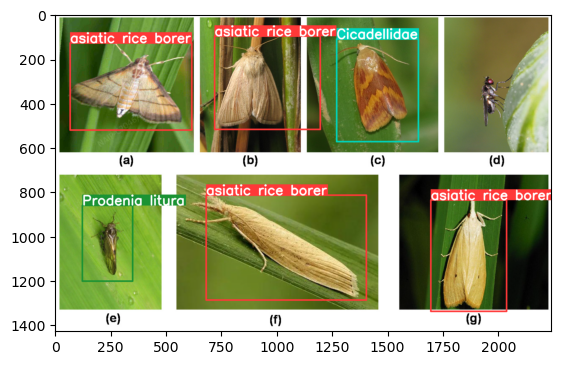

In [46]:
y_model = YOLO('./data/best.pt')

im = Image.open('/Users/sathwick/Downloads/temp.webp')
results = y_model.predict(source=im, conf=0.5)

im_bgr = results[0].plot(conf=False)
im_rgb = Image.fromarray(im_bgr[..., ::-1])

plt.imshow(im_rgb)

In [89]:
result_d = {k:[] for k in range(10)}

def get_accuracy(results):
    ctr = 0

    for result in results:
        with open(result.path.replace('images', 'labels').replace('jpg', 'txt'), 'r') as f:
            result_cls = result.boxes.cls
            cur_cls = int(f.readline().split()[0])
            if cur_cls in result_cls:
                result_d[cur_cls].append(result.path)
                ctr += 1
    return ctr/len(results) * 100

In [90]:
get_accuracy(results_all)

93.86733416770964

In [85]:
results_all = y_model.predict(source='/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/', conf=0.5)


image 1/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000008.jpg: 192x320 1 asiatic rice borer, 118.5ms
image 2/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000022.jpg: 256x320 1 asiatic rice borer, 20.3ms
image 3/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000059.jpg: 192x320 1 asiatic rice borer, 14.4ms
image 4/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000064.jpg: 224x320 1 asiatic rice borer, 21.4ms
image 5/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000074.jpg: 224x320 1 asiatic rice borer, 20.9ms
image 6/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000085.jpg: 256x320 1 asiatic rice borer, 22.9ms
image 7/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000102.jpg: 256x320 1 Prodenia litura, 23.5ms
image 8/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP00300

image 64/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000855.jpg: 256x320 1 asiatic rice borer, 21.9ms
image 65/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000857.jpg: 256x320 1 asiatic rice borer, 21.5ms
image 66/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000866.jpg: 256x320 1 asiatic rice borer, 17.9ms
image 67/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000876.jpg: 256x320 1 asiatic rice borer, 19.9ms
image 68/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000890.jpg: 256x320 1 asiatic rice borer, 22.9ms
image 69/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000909.jpg: 320x320 1 asiatic rice borer, 28.4ms
image 70/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP003000979.jpg: 288x320 1 asiatic rice borer, 24.0ms
image 71/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/image

image 129/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001101.jpg: 224x320 1 mole cricket, 17.9ms
image 130/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001158.jpg: 224x320 1 mole cricket, 15.4ms
image 131/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001213.jpg: 160x320 1 mole cricket, 12.1ms
image 132/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001216.jpg: 224x320 1 mole cricket, 18.1ms
image 133/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001235.jpg: 224x320 1 mole cricket, 16.2ms
image 134/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001243.jpg: 256x320 1 mole cricket, 16.3ms
image 135/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001287.jpg: 224x320 1 mole cricket, 18.5ms
image 136/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP015001297.jpg: 256x320 1 mole 

image 196/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001520.jpg: 288x320 1 aphids, 23.6ms
image 197/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001525.jpg: 224x320 1 aphids, 20.3ms
image 198/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001526.jpg: 192x320 1 aphids, 17.8ms
image 199/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001535.jpg: 288x320 1 aphids, 22.3ms
image 200/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001582.jpg: 288x320 1 aphids, 23.6ms
image 201/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001668.jpg: 288x320 1 aphids, 21.5ms
image 202/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001695.jpg: 320x320 1 aphids, 28.1ms
image 203/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP024001697.jpg: 224x320 1 aphids, 19.2ms
image 204/799 /Users/sathwick/SD

image 263/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000317.jpg: 192x320 1 beet army worm, 18.4ms
image 264/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000334.jpg: 224x320 1 beet army worm, 18.0ms
image 265/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000348.jpg: 256x320 1 beet army worm, 17.2ms
image 266/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000349.jpg: 288x320 1 beet army worm, 23.9ms
image 267/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000361.jpg: 192x320 1 beet army worm, 18.3ms
image 268/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000376.jpg: 224x320 1 beet army worm, 19.3ms
image 269/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000382.jpg: 256x320 1 beet army worm, 20.2ms
image 270/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP040000394.jpg: 2

image 327/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000090.jpg: 256x320 1 flax budworm, 21.9ms
image 328/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000096.jpg: 288x320 1 flax budworm, 22.3ms
image 329/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000127.jpg: 256x320 1 flax budworm, 19.1ms
image 330/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000133.jpg: 224x320 1 flax budworm, 18.8ms
image 331/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000160.jpg: 224x320 1 flax budworm, 20.0ms
image 332/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000162.jpg: 224x320 1 flax budworm, 21.0ms
image 333/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000163.jpg: 320x320 1 flax budworm, 27.4ms
image 334/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046000167.jpg: 256x320 1 flax 

image 392/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001022.jpg: 224x320 1 flax budworm, 20.4ms
image 393/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001027.jpg: 224x320 1 flax budworm, 20.0ms
image 394/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001029.jpg: 320x288 1 flax budworm, 20.3ms
image 395/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001032.jpg: 320x320 1 flax budworm, 26.4ms
image 396/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001036.jpg: 256x320 1 flax budworm, 21.6ms
image 397/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001046.jpg: 256x320 1 flax budworm, 22.1ms
image 398/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001060.jpg: 224x320 1 flax budworm, 18.9ms
image 399/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP046001063.jpg: 256x320 1 flax 

image 456/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001420.jpg: 256x320 1 blister beetle, 22.9ms
image 457/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001421.jpg: 224x320 1 blister beetle, 17.8ms
image 458/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001486.jpg: 320x224 1 blister beetle, 25.5ms
image 459/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001524.jpg: 288x320 1 blister beetle, 21.1ms
image 460/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001530.jpg: 256x320 1 blister beetle, 21.4ms
image 461/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001541.jpg: 320x192 1 blister beetle, 16.7ms
image 462/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001558.jpg: 224x320 1 blister beetle, 18.8ms
image 463/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP052001563.jpg: 3

image 519/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003289.jpg: 256x320 1 Lycorma delicatula, 19.2ms
image 520/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003363.jpg: 256x320 1 Lycorma delicatula, 17.9ms
image 521/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003415.jpg: 320x256 1 Lycorma delicatula, 16.4ms
image 522/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003424.jpg: 320x256 1 Lycorma delicatula, 17.5ms
image 523/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003597.jpg: 288x320 1 Lycorma delicatula, 17.6ms
image 524/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003601.jpg: 224x320 1 Cicadellidae, 14.9ms
image 525/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP068003602.jpg: 224x320 1 Lycorma delicatula, 14.8ms
image 526/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/ima

image 583/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001747.jpg: 192x320 1 Miridae, 14.8ms
image 584/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001778.jpg: 320x320 1 Miridae, 27.7ms
image 585/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001864.jpg: 256x320 1 Miridae, 20.9ms
image 586/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071001988.jpg: 288x320 1 Miridae, 21.5ms
image 587/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002056.jpg: 192x320 1 Miridae, 17.3ms
image 588/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002128.jpg: 224x320 1 Miridae, 17.9ms
image 589/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002192.jpg: 320x320 1 Miridae, 24.0ms
image 590/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP071002239.jpg: 320x256 1 Miridae, 21.3ms
image 591/799 /Users/sat

image 650/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000241.jpg: 224x320 1 Prodenia litura, 16.9ms
image 651/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000258.jpg: 256x320 1 Prodenia litura, 18.4ms
image 652/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000284.jpg: 256x320 1 Prodenia litura, 18.5ms
image 653/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000288.jpg: 224x320 1 Prodenia litura, 19.7ms
image 654/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000310.jpg: 320x320 1 Prodenia litura, 19.7ms
image 655/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000350.jpg: 224x320 1 Prodenia litura, 17.8ms
image 656/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000356.jpg: 192x320 1 Prodenia litura, 17.1ms
image 657/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087000392

image 714/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001178.jpg: 224x320 1 Prodenia litura, 16.0ms
image 715/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001218.jpg: 224x320 1 Prodenia litura, 17.7ms
image 716/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001227.jpg: 224x320 1 Prodenia litura, 19.4ms
image 717/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001245.jpg: 256x320 1 Prodenia litura, 20.6ms
image 718/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001254.jpg: 256x320 1 Prodenia litura, 16.2ms
image 719/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP087001257.jpg: 256x320 1 beet army worm, 16.5ms
image 720/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000125.jpg: 224x320 1 Cicadellidae, 16.9ms
image 721/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000263.jpg

image 779/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102003896.jpg: 224x320 1 Cicadellidae, 24.6ms
image 780/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004043.jpg: 256x320 1 Cicadellidae, 16.6ms
image 781/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004078.jpg: 256x320 1 Cicadellidae, 21.5ms
image 782/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004117.jpg: 256x320 1 Cicadellidae, 19.8ms
image 783/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004225.jpg: 320x256 1 Cicadellidae, 20.6ms
image 784/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004249.jpg: 320x224 1 Cicadellidae, 17.5ms
image 785/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004292.jpg: 224x320 1 Cicadellidae, 20.5ms
image 786/799 /Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102004325.jpg: 320x320 1 Cicad

In [100]:
result_d[9]

['/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000125.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000263.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000349.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000424.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000571.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000725.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000757.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000763.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000775.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000776.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/images/IP102000941.jpg',
 '/Users/sathwick/SDrive/work/pest-detection/data/test copy/image

In [ ]:
best_model = keras.models.load_model('./autoencoder/checkpoint/')

image = tf.io.read_file('/Users/sathwick/SDrive/work/tracathon/test/noise/IP003000866.jpg')
image = tf.image.decode_jpeg(image, channels=3)

noise_img = tf.image.resize(image, [304, 304]).numpy()/255 + np.random.normal(scale=0.1, size=(304, 304, 3))

plt.imshow(noise_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [114]:
plt.imsave('noise-2.jpg', np.clip(noise_img, 0., 1.))